# Define training class function


In [1]:
from sklearn.model_selection import GroupKFold, KFold, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
from numpy import mean, std

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class ModelEvaluator:
    def __init__(self, model, parameter_space, random_states, n_splits, pipeline):
        self.model = model
        self.parameter_space = parameter_space
        self.random_states = random_states
        self.n_splits = n_splits
        self.pipeline = pipeline
        self.all_results = {}
        self.X = None
        self.y = None

    def train(self, X, y, participant_ids):
        self.X = X
        self.y = y
        self.participant_ids = participant_ids

        for random_state in self.random_states:
            print(f"\nResults for Random State: {random_state}\n" + "="*40)

            outer_results = []
            cv_outer = GroupKFold(n_splits=self.n_splits)
            i = 1  # Fold counter

            for train_ix, test_ix in cv_outer.split(self.X, self.y, groups=participant_ids):
                X_train, X_test = self.X.iloc[train_ix], self.X.iloc[test_ix]
                y_train, y_test = self.y.iloc[train_ix], self.y.iloc[test_ix]

                cv_inner = KFold(n_splits=self.n_splits, shuffle=True, random_state=random_state)

                pipeline = self.pipeline.set_params(classifier__random_state=random_state)

                search = GridSearchCV(pipeline, self.parameter_space, scoring='accuracy', cv=cv_inner, refit=True,  n_jobs=-1)
                search.fit(X_train, y_train)

                best_model = search.best_estimator_
                classifier = best_model.named_steps['classifier']

                yhat = best_model.predict(X_test)

                acc = search.score(X_test, y_test)
                auc = roc_auc_score(y_test, yhat)
                cr = classification_report(y_test, yhat, output_dict=True, zero_division=1)
                cm = confusion_matrix(y_test, yhat)

                outer_results.append({'accuracy': acc, 'AUC': auc, 'classification_report': cr, 'confusion_matrix': cm})

                print(f'Best Hyperparameters in Test Fold {i}: {search.best_params_}')
                print(f'Accuracy in Test Fold {i}: {acc:.3f}')
                print(f'AUC in Test Fold {i}: {auc:.3f}\n')

                i += 1

            print("\n\n")
            self.all_results[random_state] = outer_results

    def print_and_plot_results(self):
        total_acc = []
        total_AUC = []
        per_class_cr = {label: {'precision': [], 'recall': [], 'f1-score': []} for label in ['0', '1','macro avg', 'weighted avg']}
        total_cm = np.zeros((2, 2))

        for outer_results in self.all_results.values():
            total_acc.extend([results['accuracy'] for results in outer_results])
            total_AUC.extend([results['AUC'] for results in outer_results])

            for result in outer_results:
                for label in per_class_cr:
                    result['classification_report']['weighted avg']
                    per_class_cr[label]['precision'].append(result['classification_report'][label]['precision'])
                    per_class_cr[label]['recall'].append(result['classification_report'][label]['recall'])
                    per_class_cr[label]['f1-score'].append(result['classification_report'][label]['f1-score'])
                total_cm += result['confusion_matrix']

        total_cm = total_cm/len(self.random_states)

        # Compute the average and standard deviation
        avg_acc = np.mean(total_acc)
        std_acc = np.std(total_acc)
        avg_AUC = np.mean(total_AUC)
        std_AUC = np.std(total_AUC)

        # Compute and print averaged 'macro avg' and 'weighted avg'
        print("Average Classification Report with Standard Deviation:")
        print("{:<15} {:<15} {:<15} {:<15}".format("Label", "Precision", "Recall", "F1-score"))
        print("=" * 60)

        for label in ['0', '1', 'macro avg', 'weighted avg']:
            avg_metrics = {
                'precision': np.mean(per_class_cr[label]['precision']),
                'recall': np.mean(per_class_cr[label]['recall']),
                'f1-score': np.mean(per_class_cr[label]['f1-score'])
            }
            std_metrics = {
                'precision': np.std(per_class_cr[label]['precision']),
                'recall': np.std(per_class_cr[label]['recall']),
                'f1-score': np.std(per_class_cr[label]['f1-score'])
            }
            print(f"{label:<15} {avg_metrics['precision']:.3f} (±{std_metrics['precision']:.3f})  {avg_metrics['recall']:.3f} (±{std_metrics['recall']:.3f})  {avg_metrics['f1-score']:.3f} (±{std_metrics['f1-score']:.3f})")

        # Print results
        print(f"Averaged accuracy: {avg_acc:.3f} (±{std_acc:.3f})")
        print(f"Averaged AUC: {avg_AUC:.3f} (±{std_AUC:.3f})\n")

        # Plot the average confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(total_cm, annot=True, fmt="g", cmap="Blues", cbar=True,
                    xticklabels=['Predicted Truthful', 'Predicted Deceptive'],
                    yticklabels=['Actual Truthful', 'Actual Deceptive'])
        plt.title("Average Confusion Matrix across random states")

# Bow Classifier

## Load and preprocess data



In [ ]:
import pandas as pd

# Display all columns in the dataset
pd.options.display.max_columns = None

data = pd.read_csv('/content/Embedded_Lies_for_ML.csv', sep = ',')
data.head()

,Participant_id,Event,Text,Text_clean,Condition
0,660687a02630547fb296d754,Taking the bus/train without the ticket,I was in a city nearby my hometown. I was goin...,city nearby hometown go application process jo...,0
1,65391353897d68dd53a067da,Ending a long romantic relationship,It was a 5 year relationship and we were very ...,5 year relationship attached cheat lie find go...,0
2,615b2ee8616d1b05551794ee,A job interview for your dream job,It was on the 14th of February when I walked i...,14th february walk gate institution interview ...,0
3,616dc201c0b58a25890f4b94,Ending a long romantic relationship,My partner and I were in a long distance relat...,partner long distance relationship relocate to...,0
4,5b6034ba0ced0a00017ba9b9,Missing a deadline at work because of bad orga...,we had to plan a celebration for our departmen...,plan celebration department weekend april cele...,0


In [ ]:
data.shape

(2088, 5)

### Testing the code to see the output of the BOW model on a small section of the dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'data' is your DataFrame with 'Text_clean' and 'Participant id' columns
X = data['Text_clean']
participant_ids = data['Participant_id']

# Create a GroupKFold object with 1 split (for visualization purposes)
cv_outer = GroupKFold(n_splits=2)  # for demonstration

# Get the train and test indices for the first split
for train_ix, test_ix in cv_outer.split(X, groups=participant_ids):
    break

X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]

# Create a CountVectorizer to generate the bag-of-words representation
vectorizer = CountVectorizer(#max_df=0.8,
                             min_df=0.05,
                             ngram_range = (1,3))
X_train_bow = vectorizer.fit_transform(X_train)

# Create a DataFrame for visualization
bow_df = pd.DataFrame(X_train_bow.toarray(), columns=vectorizer.get_feature_names_out())

# Display the DataFrame (you can adjust the number of rows/columns to display)
print(bow_df.head())

   10  able  ago  answer  apply  arrive  ask  away  bad  big  bit  break  bus  \
0   0     0    0       0      0       1    0     0    0    0    0      0    7   
1   0     0    0       0      0       0    0     0    0    0    0      2    0   
2   0     0    0       0      0       0    0     0    0    0    0      1    0   
3   0     0    0       0      0       0    0     0    0    0    0      0    0   
4   0     0    0       0      0       0    0     0    0    0    0      1    0   

   buy  call  car  catch  cause  change  check  city  close  come  company  \
0    0     0    0      0      0       0      0     2      0     0        1   
1    0     0    1      0      0       0      0     0      0     0        0   
2    1     0    0      0      0       0      0     0      0     0        0   
3    0     0    0      0      0       0      0     0      0     0        0   
4    0     0    0      0      0       0      0     0      0     1        0   

   complete  date  day  deadline  decide  di

In [ ]:
bow_df.shape

(1044, 158)

In [ ]:
bow_df

,10,able,ago,answer,apply,arrive,ask,away,bad,big,bit,break,bus,buy,call,car,catch,cause,change,check,city,close,come,company,complete,date,day,deadline,decide,different,dream,dream job,drive,early,end,event,exam,experience,explain,family,feel,finally,find,fine,finish,forget,friend,get,give,go,good,great,happen,happy,hard,have,help,home,hospital,hour,house,interview,job,keep,know,late,later,leave,let,life,like,little,live,long,look,lose,lot,love,manage,mean,meet,memorable,minute,miss,moment,money,month,month ago,morning,need,nervous,new,night,not,notice,offer,old,partner,pass,past,pay,people,person,phone,place,plan,point,position,prepare,problem,question,realize,reason,receive,relationship,remember,result,right,room,run,say,see,send,sit,speed,spend,start,stay,stop,study,sure,surgery,take,talk,task,team,tell,thing,think,ticket,time,train,travel,trip,try,turn,unfortunately,university,wait,wake,walk,want,way,week,well,work,write,year
0,0,0,0,0,0,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0,2,0,0,1,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,1,0,3,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1
1040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,2,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,1,0,1,0,3,0,1,0,4,0,0,0,0,1,1,2,0,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2,0,1,1,0,0,1,2,0,0,0,0,0,1,0,0,0,0,0,2,0,0,3,2,1,0,2,0,0,0,2,0,0,0,0,0,0,5,0,0,1,2,0,0
1041,0,0,0,0,0,0,2,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,2,0,2,0,0,0,0,0,0,0,3,0,1,1,0,0,0,2,1,1,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Random Forest

In [ ]:
# Define the features and the target
X = data['Text_clean']
y = data['Condition_labels']
participant_ids = data['Participant_id']

In [ ]:
# Define the model and parameter space
random_states = [290893]
n_splits = 10
model = RandomForestClassifier
parameter_space = {'classifier__n_estimators': [100, 200],
                   'classifier__max_depth': [None, 5, 10]}
pipeline = Pipeline([('bow', CountVectorizer(min_df=0.05, ngram_range = (1,3))),
                     ('classifier', model())])

# Instantiate the class
evaluator = ModelEvaluator(model, parameter_space, random_states=random_states, n_splits=n_splits, pipeline=pipeline)

In [ ]:
# Train and test the model with nested cross validation and three random states
evaluator.train(X, y, participant_ids)


Results for Random State: 290893
Best Hyperparameters in Test Fold 1: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 1: 0.519
AUC in Test Fold 1: 0.519

Best Hyperparameters in Test Fold 2: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 2: 0.533
AUC in Test Fold 2: 0.533

Best Hyperparameters in Test Fold 3: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 3: 0.576
AUC in Test Fold 3: 0.576

Best Hyperparameters in Test Fold 4: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 4: 0.586
AUC in Test Fold 4: 0.586

Best Hyperparameters in Test Fold 5: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 5: 0.567
AUC in Test Fold 5: 0.567

Best Hyperparameters in Test Fold 6: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 6: 0.572
AUC in Test Fold 6: 0.572

Best Hyperparameters in 

Average Classification Report with Standard Deviation:
Label           Precision       Recall          F1-score       
0               0.547 (±0.027)  0.534 (±0.038)  0.540 (±0.029)
1               0.545 (±0.025)  0.558 (±0.040)  0.551 (±0.030)
macro avg       0.546 (±0.026)  0.546 (±0.026)  0.545 (±0.026)
weighted avg    0.546 (±0.026)  0.546 (±0.026)  0.545 (±0.026)
Averaged accuracy: 0.546 (±0.026)
Averaged AUC: 0.546 (±0.026)



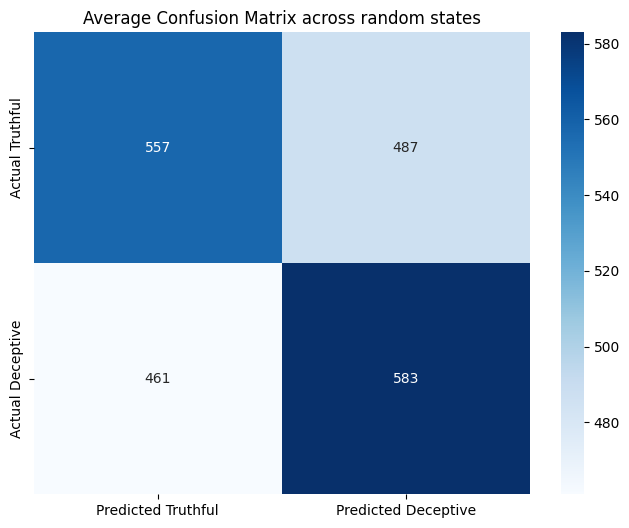

In [ ]:
# Model metrics:
evaluator.print_and_plot_results()

# LIWC Classifier

## Load and preprocess data

In [9]:
# Load datasets
import pandas as pd

liwc_df = pd.read_csv('/content/LIWC_dataset.csv')
print("Shape liwc_df", liwc_df.shape)
liwc_df.head()

Shape liwc_df (2084, 121)


,Participant id,Condition,Event,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,660687a02630547fb296d754,Truthful,Taking the bus/train without the ticket,190,55.49,7.50,99.00,35.11,17.27,14.21,...,0.0,0.0,8.95,5.26,3.16,0.0,0.53,0.00,0.00,0.0
1,65391353897d68dd53a067da,Truthful,Ending a long romantic relationship,152,1.88,10.72,81.34,1.00,13.82,16.45,...,0.0,0.0,10.53,7.24,2.63,0.0,0.00,0.66,0.00,0.0
2,615b2ee8616d1b05551794ee,Truthful,A job interview for your dream job,129,78.39,6.24,93.24,56.53,16.13,20.93,...,0.0,0.0,10.85,6.20,4.65,0.0,0.00,0.00,0.00,0.0
3,616dc201c0b58a25890f4b94,Truthful,Ending a long romantic relationship,256,24.22,25.34,72.92,20.23,19.69,10.94,...,0.0,0.0,7.03,4.69,1.56,0.0,0.00,0.00,0.78,0.0
4,5b6034ba0ced0a00017ba9b9,Truthful,Missing a deadline at work because of bad orga...,119,68.82,97.84,64.51,59.80,19.83,19.33,...,0.0,0.0,10.92,5.88,3.36,0.0,0.00,0.00,1.68,0.0


In [10]:
# Transform Condition labels into 0/1 numbers
liwc_df['Condition'] = liwc_df['Condition'].replace({'Truthful': 0, 'Deceptive': 1})

<ipython-input-10-a174df931d81>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  liwc_df['Condition'] = liwc_df['Condition'].replace({'Truthful': 0, 'Deceptive': 1})


In [ ]:
# Drop Tone column in liwc_df
#liwc_df = liwc_df.drop('Tone', axis=1)

## Random Forest

In [11]:
# Define the features and the target
X = liwc_df.drop(['Participant id','Condition','Event'], axis=1)
y = liwc_df['Condition']
participant_ids = liwc_df['Participant id']

In [12]:
# Define the model and parameter space
random_states = [290893]
n_splits = 10
model = RandomForestClassifier
parameter_space = {'classifier__n_estimators': [100, 200],
                   'classifier__max_depth': [None, 5, 10]}
pipeline = Pipeline([('imputer', KNNImputer(n_neighbors=5)),
                     ('transformer', StandardScaler()),
                     ('classifier', model())])

# Instantiate the class
evaluator = ModelEvaluator(model, parameter_space, random_states=random_states, n_splits=n_splits, pipeline=pipeline)

In [13]:
# Train and test the model with nested cross validation and three random states
evaluator.train(X, y, participant_ids)


Results for Random State: 290893
Best Hyperparameters in Test Fold 1: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 1: 0.576
AUC in Test Fold 1: 0.576

Best Hyperparameters in Test Fold 2: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 2: 0.548
AUC in Test Fold 2: 0.548

Best Hyperparameters in Test Fold 3: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 3: 0.577
AUC in Test Fold 3: 0.577

Best Hyperparameters in Test Fold 4: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 4: 0.519
AUC in Test Fold 4: 0.519

Best Hyperparameters in Test Fold 5: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 5: 0.601
AUC in Test Fold 5: 0.601

Best Hyperparameters in Test Fold 6: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 6: 0.548
AUC in Test Fold 6: 0.548

Best Hyperparameters in 

Average Classification Report with Standard Deviation:
Label           Precision       Recall          F1-score       
0               0.578 (±0.032)  0.553 (±0.033)  0.565 (±0.027)
1               0.571 (±0.026)  0.595 (±0.050)  0.582 (±0.035)
macro avg       0.574 (±0.029)  0.574 (±0.028)  0.573 (±0.028)
weighted avg    0.574 (±0.029)  0.574 (±0.028)  0.573 (±0.028)
Averaged accuracy: 0.574 (±0.028)
Averaged AUC: 0.574 (±0.028)



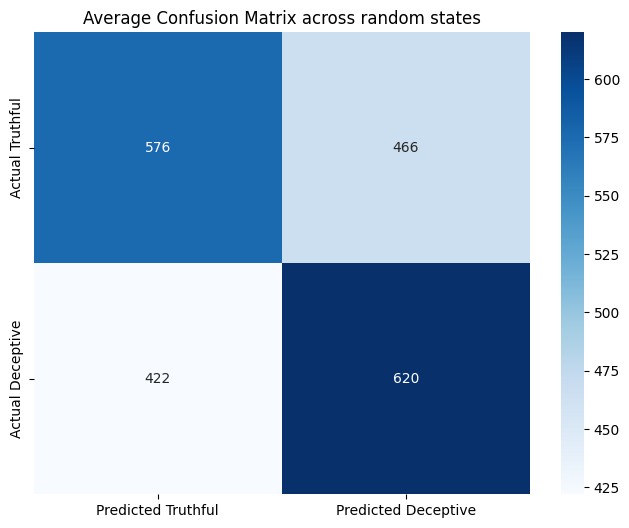

In [14]:
# Model metrics:
evaluator.print_and_plot_results()

# DeCLaRatiVE Classifier

## Load and preprocess data

In [15]:
# Load datasets
import pandas as pd

decl_df = pd.read_csv('/content/declarative_dataset.csv')
print("Shape liwc_df", decl_df.shape)
decl_df.head()

Shape liwc_df (2084, 29)


,num_sentences,num_words,num_syllables,avg_syllables_per_word,fk_grade,fk_read,Analytic,Authentic,Tone,tone_pos,...,Perceptual Details,Reality Monitoring,Temporal details,Spatial details,Quantity details,People,concreteness,Condition,Participant_id,Event
0,11,190,242,1.273684,6.5,79.30,55.49,99.00,35.11,1.58,...,0.00,8.43,1.570681,0.0,0.523560,0.0,3.150217,Truthful,660687a02630547fb296d754,Taking the bus/train without the ticket
1,11,152,199,1.309211,5.1,82.85,1.88,81.34,1.00,0.00,...,1.97,2.63,0.653595,0.0,0.000000,0.0,2.975676,Truthful,65391353897d68dd53a067da,Ending a long romantic relationship
2,8,129,188,1.457364,8.4,63.59,78.39,93.24,56.53,3.10,...,1.56,12.41,1.550388,0.0,2.325581,0.0,2.885789,Truthful,615b2ee8616d1b05551794ee,A job interview for your dream job
3,13,256,326,1.273438,7.4,76.86,24.22,72.92,20.23,1.56,...,1.56,12.49,3.846154,0.0,0.000000,0.0,3.383030,Truthful,616dc201c0b58a25890f4b94,Ending a long romantic relationship
4,7,118,186,1.576271,9.9,54.32,68.82,64.51,59.80,3.36,...,0.00,9.25,5.882353,0.0,0.000000,0.0,3.182059,Truthful,5b6034ba0ced0a00017ba9b9,Missing a deadline at work because of bad orga...


In [16]:
# Transform Condition labels into 0/1 numbers
decl_df['Condition'] = decl_df['Condition'].replace({'Truthful': 0, 'Deceptive': 1})

<ipython-input-16-fa34005c466b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  decl_df['Condition'] = decl_df['Condition'].replace({'Truthful': 0, 'Deceptive': 1})


## Random Forest

In [19]:
# Define the features and the target
X = decl_df.drop(['Participant_id','Condition','Event'], axis=1)
y = decl_df['Condition']
participant_ids = decl_df['Participant_id']

In [20]:
# Define the model and parameter space
random_states = [290893]
n_splits = 10
model = RandomForestClassifier
parameter_space = {'classifier__n_estimators': [100, 200],
                   'classifier__max_depth': [None, 5, 10]}
pipeline = Pipeline([('imputer', KNNImputer(n_neighbors=5)),
                                     ('transformer', StandardScaler()),
                                     ('classifier', model())])

# Instantiate the class
evaluator = ModelEvaluator(model, parameter_space, random_states=random_states, n_splits=n_splits, pipeline=pipeline)

In [21]:
# Train and test the model with nested cross validation and three random states
evaluator.train(X, y, participant_ids)


Results for Random State: 290893
Best Hyperparameters in Test Fold 1: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 1: 0.557
AUC in Test Fold 1: 0.557

Best Hyperparameters in Test Fold 2: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 2: 0.567
AUC in Test Fold 2: 0.567

Best Hyperparameters in Test Fold 3: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 3: 0.558
AUC in Test Fold 3: 0.558

Best Hyperparameters in Test Fold 4: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 4: 0.543
AUC in Test Fold 4: 0.543

Best Hyperparameters in Test Fold 5: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 5: 0.538
AUC in Test Fold 5: 0.538

Best Hyperparameters in Test Fold 6: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 6: 0.553
AUC in Test Fold 6: 0.553

Best Hyperparameters in 

Average Classification Report with Standard Deviation:
Label           Precision       Recall          F1-score       
0               0.556 (±0.021)  0.548 (±0.063)  0.550 (±0.035)
1               0.555 (±0.022)  0.562 (±0.058)  0.557 (±0.030)
macro avg       0.556 (±0.020)  0.555 (±0.020)  0.554 (±0.020)
weighted avg    0.556 (±0.020)  0.555 (±0.020)  0.554 (±0.020)
Averaged accuracy: 0.555 (±0.020)
Averaged AUC: 0.555 (±0.020)



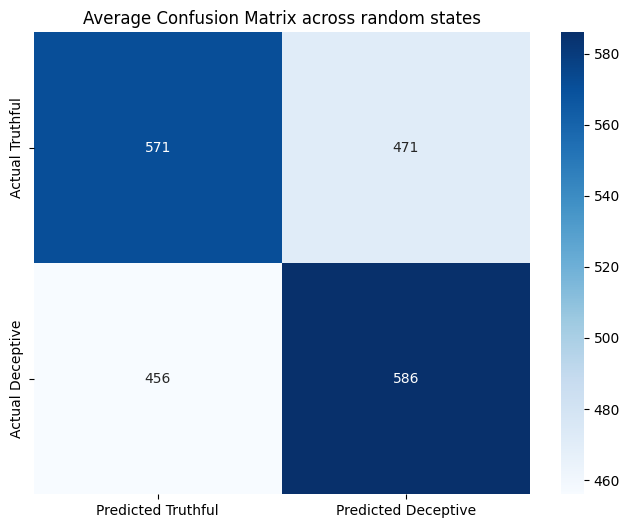

In [22]:
# Model metrics:
evaluator.print_and_plot_results()

# GPT-embeddings



## Load data and compute embeddings

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.1 MB/s eta 0:00:00


In [ ]:
# Load & inspect dataset

data = pd.read_csv("/content/Embedded_Lies_for_ML.csv", sep =',', index_col=0)
data.head()

,Event,Text,Text_clean,Condition
Participant_id,,,,
660687a02630547fb296d754,Taking the bus/train without the ticket,I was in a city nearby my hometown. I was goin...,city nearby hometown go application process jo...,0
65391353897d68dd53a067da,Ending a long romantic relationship,It was a 5 year relationship and we were very ...,5 year relationship attached cheat lie find go...,0
615b2ee8616d1b05551794ee,A job interview for your dream job,It was on the 14th of February when I walked i...,14th february walk gate institution interview ...,0
616dc201c0b58a25890f4b94,Ending a long romantic relationship,My partner and I were in a long distance relat...,partner long distance relationship relocate to...,0
5b6034ba0ced0a00017ba9b9,Missing a deadline at work because of bad orga...,we had to plan a celebration for our departmen...,plan celebration department weekend april cele...,0


In [ ]:
# Check the number of tokens in the dataset: the maximum number of tokens for text-embedding-3-large is 8191
import tiktoken

# Define the encoding for our specific model
encoding = tiktoken.encoding_for_model("text-embedding-3-large")

# visualize number of tokens for embedding
data["n_tokens"] = data['Text'].apply(lambda x: len(encoding.encode(x)))
data.describe()

,Condition,n_tokens
count,2088.00000,2088.000000
mean,0.50000,156.715038
std,0.50012,95.555119
min,0.00000,55.000000
25%,0.00000,90.000000
50%,0.50000,129.000000
75%,1.00000,187.250000
max,1.00000,838.000000


In [ ]:
# Import OpenAI and the API key
from openai import OpenAI

api_key = "INSERT_YOR_API_KEY_HERE"
client = OpenAI(api_key=api_key)

# Define a function to compute embeddings
def get_embedding(text, model="text-embedding-3-large", dimensions=256):
   text = text.replace("\n", " ")
   return client.embeddings.create(input=[text], model=model, dimensions=dimensions).data[0].embedding

In [ ]:
# Apply the function in our dataset
data['gpt_embedding'] = data['Text'].apply(lambda x: get_embedding(x, model='text-embedding-3-large'))
data.head()

,Event,Text,Text_clean,Condition,n_tokens,gpt_embedding
Participant_id,,,,,,
660687a02630547fb296d754,Taking the bus/train without the ticket,I was in a city nearby my hometown. I was goin...,city nearby hometown go application process jo...,0,207,"[0.041554056107997894, 0.061757542192935944, -..."
65391353897d68dd53a067da,Ending a long romantic relationship,It was a 5 year relationship and we were very ...,5 year relationship attached cheat lie find go...,0,169,"[0.07408972084522247, 0.013070516288280487, -0..."
615b2ee8616d1b05551794ee,A job interview for your dream job,It was on the 14th of February when I walked i...,14th february walk gate institution interview ...,0,152,"[0.045688021928071976, 0.04817028343677521, -0..."
616dc201c0b58a25890f4b94,Ending a long romantic relationship,My partner and I were in a long distance relat...,partner long distance relationship relocate to...,0,279,"[0.0387028269469738, 0.023377783596515656, 0.0..."
5b6034ba0ced0a00017ba9b9,Missing a deadline at work because of bad orga...,we had to plan a celebration for our departmen...,plan celebration department weekend april cele...,0,135,"[0.03289545327425003, -0.02223089523613453, -0..."


In [ ]:
# Check for the length of embeddings
len(data['gpt_embedding'].iloc[0])

256

In [ ]:
data = data.reset_index()
data.head(2)

,Participant_id,Event,Text,Text_clean,Condition,n_tokens,gpt_embedding
0,660687a02630547fb296d754,Taking the bus/train without the ticket,I was in a city nearby my hometown. I was goin...,city nearby hometown go application process jo...,0,207,"[0.041554056107997894, 0.061757542192935944, -..."
1,65391353897d68dd53a067da,Ending a long romantic relationship,It was a 5 year relationship and we were very ...,5 year relationship attached cheat lie find go...,0,169,"[0.07408972084522247, 0.013070516288280487, -0..."


In [ ]:
data.to_csv('gpt_embeddings.csv', sep=';', index=False)

## Random Forest

In [ ]:
# Define the features and the target
X = pd.DataFrame(data['gpt_embedding'].to_list(), index= data.index) # make it in the form of a dataset
y = data['Condition_labels']
participant_ids = data['Participant_id']

In [ ]:
# Define the model and parameter space
random_states = [290893]
n_splits = 10
model = RandomForestClassifier
parameter_space = {'classifier__n_estimators': [100, 200],
                   'classifier__max_depth': [None, 5, 10]}
pipeline = Pipeline([('classifier', model())])

# Instantiate the class
evaluator = ModelEvaluator(model, parameter_space, random_states=random_states, n_splits=n_splits, pipeline=pipeline)

In [ ]:
# Train and test the model with nested cross validation and three random states
evaluator.train(X, y, participant_ids)


Results for Random State: 290893
Best Hyperparameters in Test Fold 1: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 1: 0.633
AUC in Test Fold 1: 0.633

Best Hyperparameters in Test Fold 2: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 2: 0.667
AUC in Test Fold 2: 0.667

Best Hyperparameters in Test Fold 3: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 3: 0.586
AUC in Test Fold 3: 0.586

Best Hyperparameters in Test Fold 4: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 4: 0.590
AUC in Test Fold 4: 0.590

Best Hyperparameters in Test Fold 5: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy in Test Fold 5: 0.654
AUC in Test Fold 5: 0.654

Best Hyperparameters in Test Fold 6: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy in Test Fold 6: 0.635
AUC in Test Fold 6: 0.635

Best Hyperparameters in 

Average Classification Report with Standard Deviation:
Label           Precision       Recall          F1-score       
0               0.618 (±0.031)  0.604 (±0.065)  0.610 (±0.046)
1               0.615 (±0.038)  0.628 (±0.042)  0.620 (±0.032)
macro avg       0.617 (±0.034)  0.616 (±0.035)  0.615 (±0.035)
weighted avg    0.617 (±0.034)  0.616 (±0.035)  0.615 (±0.035)
Averaged accuracy: 0.616 (±0.035)
Averaged AUC: 0.616 (±0.035)



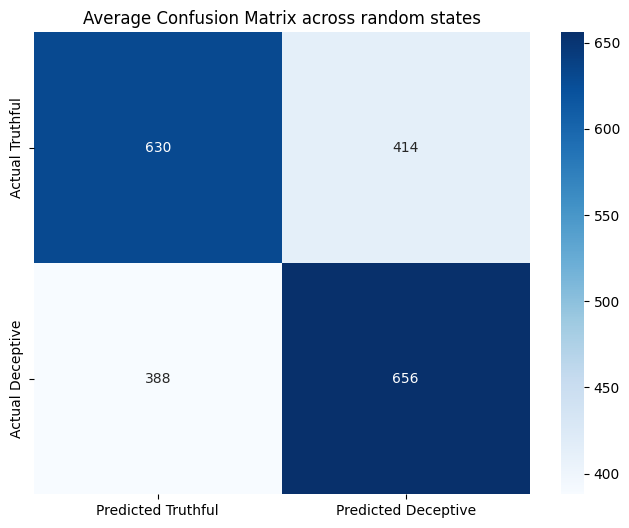

In [ ]:
# Model metrics:
evaluator.print_and_plot_results()